In [ ]:
import jax.numpy as jnp
import jax
import numpy as np
import sys
sys.path.append('/home/miguel/Projects/uni/phd/smlm_z')
from data.visualise import grid_psfs, show_psf_axial
def rms2(ab, pupil):
    return np.sqrt(np.sum(ab**2) / np.sum(pupil <= 1))

import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

try:
    import cupy as cp

    print('cupy imported')
    import_cp = True
except:
    import_cp = False

import matplotlib.pyplot as plt


def rms(pupil):
    return jnp.sqrt(jnp.mean(jnp.abs(pupil)**2))
          
def norm_zero_one(psf):
    return (psf - psf.min()) / (psf.max() - psf.min())


import poppy 

KR = None
THETA = None
class Simulator:
    
    
# pixel size (nm) - 115
# step size (nm) - 20nm
# magnification - 100x
# illumination NA
# NA at sample
# refractive index at sample - PBS so 1.335
# illumination wavelength - 635nm
# detection wavelength - to check


# #     N = 2048  # points to use in FFT
#     Nn = 32
#     pixel_size = 0.115  # camera pixel size
#     zrange = 1.0  # distance either side of focus to calculate, in microns, could be arbitrary
#     dz = 0.02  # step size in axial direction of PSF
    
#     magnification = 100  # objective magnification
#     ill_NA = 1.4  # numerical aperture at illumination beams
#     det_NA = 1.1  # numerical aperture at sample
#     n = 1.335  # refractive index at sample
#     fwhmz = 3.0  # FWHM of light sheet in z

#     ill_wavelength = 635  # illumination wavelength in nm
#     det_wavelength = 635  # detection wavelength in nm

    def __init__(self, Nn=32, n_coefs=32, pixel_size=0.90, zrange=1.0, dz=0.02, magnification=100, ill_NA=1.4, det_NA=1.1, n=1.335, fwhmz=3.0, ill_wavelength=635, det_wavelength=635):
        self.Nn = Nn # lateral size of output PSF
        self.pixel_size = pixel_size
        self.zrange = zrange
        self.dz = dz # step size in axial direction of PSF
        self.magnification = magnification
        self.ill_NA = ill_NA # numerical aperture at illumination beams
        self.ill_wavelength = ill_wavelength # illumination wavelength in nm
        self.det_NA = det_NA # numerical aperture at sample
        self.det_wavelength = det_wavelength # detection wavelength in nm
        
        self.n = n # refractive index at sample
        self.fwhmz = fwhmz
        
        
#         np.random.seed(RANDOM_SEED)
        # self.seed(1234)  # set random number generator seed
        self.ill_wavelength = self.ill_wavelength * 1e-3
        self.det_wavelength = self.det_wavelength * 1e-3
        self.sigmaz = self.fwhmz / 2.355
        self.dx = self.pixel_size / self.magnification  # Sampling in lateral plane at the sample in um
        self.dxn = self.det_wavelength / (4 * self.det_NA)  # 2 * Nyquist frequency in x and y.
#         self.Nn = int(np.ceil(self.N * self.dx / self.dxn / 2) * 2)  # Number of points at Nyquist sampling, even number
        
        self.N = self.Nn * (self.det_wavelength / (4 * self.det_NA)) / (self.pixel_size / self.magnification)

        self.dxn = self.N * self.dx / self.Nn  # correct spacing
        self.res = self.det_wavelength / (2 * self.det_NA)
        oversampling = self.res / self.dxn  # factor by which pupil plane oversamples the coherent psf data
        self.dk = oversampling / (self.Nn / 2)  # Pupil plane sampling
        self.k0 = 2 * jnp.pi * self.n / self.det_wavelength
        self.kx, self.ky = jnp.meshgrid(jnp.linspace(-self.dk * self.Nn / 2, self.dk * self.Nn / 2 - self.dk, self.Nn),
                                       jnp.linspace(-self.dk * self.Nn / 2, self.dk * self.Nn / 2 - self.dk, self.Nn))
        self.kr = jnp.sqrt(self.kx ** 2 + self.ky ** 2)  # Raw pupil function, pupil defined over circle of radius 1.
        
        self.krmax = self.det_NA * self.k0 / self.n
        self.kr2 = self.kx ** 2 + self.ky ** 2
        self.csum = sum(sum((self.kr < 1)))  # normalise by csum so peak intensity is 1

        self.alpha = jnp.arcsin(self.det_NA / self.n)
        # Nyquist sampling in z, reduce by 10 % to account for gaussian light sheet
        self.dzn = 0.8 * self.det_wavelength / (2 * self.n * (1 - jnp.cos(self.alpha)))
        self.Nz = int(2 * jnp.ceil(self.zrange / self.dz))
        self.dz = 2 * self.zrange / self.Nz
        self.Nzn = int(2 * jnp.ceil(self.zrange / self.dzn))
        self.dzn = 2 * self.zrange / self.Nzn
        if self.Nz < self.Nzn:
            self.Nz = self.Nzn
            self.dz = self.dzn
        else:
            self.Nzn = self.Nz
            self.dzn = self.dz
            
        self.n_coefs = n_coefs
        self.zerns = jnp.zeros((n_coefs, Nn, Nn))

        theta = jnp.arctan2(self.ky, self.kx)
        
        masked_pupil = np.array(self.kr)
        masked_pupil[masked_pupil > 1] = 0
        masked_pupil = norm_zero_one(masked_pupil)
        
        KR = np.array(self.kr)
        THETA = np.array(theta)
#         plt.imshow(KR)
#         plt.colorbar()
#         plt.show()
#         plt.imshow(THETA)
#         plt.colorbar()
#         plt.show()
        
        for i in range(n_coefs):
            self.zerns = self.zerns.at[i, :, :].set(poppy.zernike.zernike1(i+1, outside=0.0, rho=masked_pupil, theta=np.array(theta)))
            
            self.zerns = self.zerns.at[i].set(self.zerns[i] * (self.kr<1).astype(int))
#             print(rms2(self.zerns[i], self.kr))
        
    def get_scalar_psf(self, offset=0, zern_coefs=None):

#         extra_aberration = jnp.zeros(self.kr.shape)
#         aberrations = jnp.array([
#             jnp.ones(self.kr.shape), # piston
#             2 * self.kx, # tipx
#             2 * self.ky, # tilt
#             jnp.sqrt(3) * ((2 * (self.kr**2)) - 1), # defocus
#             2 * jnp.sqrt(6) * (self.kx * self.ky), # vertical astigmatism
#             jnp.sqrt(6) * (self.kx**2 - self.ky ** 2), # oblique astigmatism
#             2 * jnp.sqrt(2) * (3 * self.kr**2 - 2) * self.ky, # horizontal coma
#             2 * jnp.sqrt(2) * (3 * self.kr**2 - 2) * self.kx, # vertical coma
#             2 * jnp.sqrt(2) * (3 * self.kr**2 - 4 * self.kr**2) * self.ky, # vertical trefoil 
#             2 * jnp.sqrt(2) * (4 * self.kx**2 - 3 * self.kr**2) * self.kx, # oblique trefoil 
#             jnp.sqrt(5) * (6 * self.kr**2 * (self.kr**2 - 1) + 1), # primary spherical
#             jnp.sqrt(10) * (8 * self.kx**4 - 8 * self.kx**2 * self.ky**2 - (3 * self.kx ** 2)), # vertical secondary astigmatism
#             jnp.sqrt(10) * (4 * self.kx * self.ky) * (4 * self.kx**2 + 4 * self.ky**2 - 3), # oblique secondary astigmatism
#             jnp.sqrt(10) * ((self.kx**2 - self.ky**2) * (4*self.kx**2 - 3)) ** 2, # vertical quadrafoil
#             jnp.sqrt(10) * ((2 * self.kx * self.ky) * (self.kx**2 - self.ky**2)) ** 2 # oblique quadrafoil
#         ])
    

        
        
#         for custom, p in zip(aberrations, self.zerns):
#             import numpy as np
# #             custom = custom.at[~(self.kr<1)].set(0)
#             custom = norm_zero_one(custom.copy())
#             p = norm_zero_one(p.copy())
#             plt.imshow(np.concatenate((custom, p), axis=1))
#             plt.show()
#             print(custom.min(), custom.max())
#             print(p.min(), p.max())
#         return
        

    
#         if zern_coefs is not None:
#             n_coefs = zern_coefs.shape[0]
#             aberrations = aberrations[:n_coefs]
#             cust_extra_aberration = jnp.multiply(aberrations, zern_coefs[:, jnp.newaxis, jnp.newaxis]).sum(axis=0)
#         else:
#             cust_extra_aberration = 0

        if zern_coefs is not None:
            extra_aberration = jnp.sum(self.zerns * zern_coefs[:, jnp.newaxis, jnp.newaxis], axis=0)
        else:
            extra_aberration = 0

        pupil = self.kr < 1
        
#         rms_val = rms2(extra_aberration, pupil)
#         print(np.median(extra_aberration))
#         plt.title(f'RMS: {rms_val:.2E} min: {extra_aberration.min():.2E} max: {extra_aberration.max():.2E}')
        
#         plt.imshow(extra_aberration)
#         plt.show()
        
        
#         pupil = pupil *  np.exp(1j* aberrations)
#         nz = 0
#         psf = self.xp.zeros((self.Nzn, self.Nn, self.Nn))
#         for z in np.arange(-self.zrange, self.zrange - self.dzn, self.dzn):
#             c = (np.exp(
#                 1j * (z * self.n * 2 * np.pi / self.det_wavelength *
#                       np.sqrt(1 - (self.kr * pupil) ** 2 * self.det_NA ** 2 / self.n ** 2)))) * pupil
#             psf.at[nz, :, :].set(abs(np.fft.fftshift(np.fft.ifft2(c))) ** 2 * np.exp(-z ** 2 / 2 / self.sigmaz ** 2))
#             nz = nz + 1
    

#     With aberrations
#         nz = 0
#         psf = self.xp.zeros((self.Nzn, self.Nn, self.Nn))
#         for z in np.arange(-self.zrange, self.zrange - self.dzn, self.dzn):
#             c = (np.exp(1j * (extra_aberration + z * self.n * 2 * np.pi / self.det_wavelength *
#                       np.sqrt(1 - (self.kr * pupil) ** 2 * self.det_NA ** 2 / self.n ** 2)))) * pupil
#             psf = psf.at[nz, :, :].set(abs(np.fft.fftshift(np.fft.ifft2(c))) ** 2 * np.exp(-z ** 2 / 2 / self.sigmaz ** 2))
#             nz = nz + 1

        # Optimised version
        mult1 = self.n * 2 * jnp.pi / self.det_wavelength * jnp.sqrt(1 - (self.kr * pupil) ** 2 * self.det_NA ** 2 / self.n ** 2)
        zs = jnp.arange(-self.zrange, self.zrange, self.dzn) + offset
        cs = jax.lax.map(lambda z: (jnp.exp(1j * (extra_aberration + (z * mult1)))) * pupil, zs)
        cs_psf = abs(jnp.fft.fftshift(jnp.fft.ifft2(cs, axes=(1,2)), axes=(1,2))) ** 2
        psf = jnp.multiply(cs_psf, jnp.exp(-zs ** 2 / 2 / self.sigmaz ** 2)[:, jnp.newaxis, jnp.newaxis])
                                
        # Normalised so power in resampled psf(see later on) is unity in focal plane
        psf = psf * self.Nn ** 2 / jnp.sum(pupil) * self.Nz / self.Nzn

        return psf


In [ ]:
import numpy as np
from sklearn.metrics import euclidean_distances
import seaborn as sns
import matplotlib.pyplot as plt

s = np.linspace(-1, 1, 25)
x, y = np.meshgrid(s, s)
x = x.flatten()
y = y.flatten()
xy = np.stack((x,y)).T

dists = euclidean_distances([[0, 0]], xy).squeeze()
dists = np.power(dists, 1)
dists /= dists.max()
sns.scatterplot(x=x, y=y, hue=dists)
plt.show()

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import euclidean_distances
import seaborn as sns
# model_kwargs = dict(
#     wl=647,
#     na=1.3,
#     ni=1.51,
#     res=90,
#     zres=10,
#     size=32,
#     zsize=200,
#     vec_corr="none",
#     condition="none",
# )
# from pyotf.otf import HanserPSF, apply_aberration, apply_named_aberration

def get_ab(a1, a2):
    base_args = np.array([0.0, 0.0, 0.0, 0.5, a1, a2])
    return base_args
    
# def gen_fake_psf(model_kwargs, ab):
#     model = HanserPSF(**model_kwargs)
#     # model = apply_named_aberration(model, 'oblique astigmatism', 2)
#     model = apply_aberration(model, np.zeros(ab.shape), ab)

#     psf = model.PSFi
#     psf = psf.astype(float)
#     # psf = psf / psf.max()
    
#     return psf

# def add_noise(psf):
#     return psf + np.random.normal(0, 5e-4, size=psf.shape)

coords = []
psfs = []

n_points = 50

lim = 1
xy = np.random.uniform(-1, 1, size=(n_points, 2))
# xy = np.stack([np.linspace(-lim, lim, n_points), np.linspace(-lim, lim, n_points)]).T
center = [[0, 0]]
dists = euclidean_distances(xy, center).squeeze()
# dists = 2**dists
dists = np.power(dists, 1.2)
dists /= dists.max()

a1s = []
a2s = []


optical_params = dict(Nn=31, 
                          pixel_size=0.115, 
                          zrange=1.5, 
                          dz=0.02, 
                          magnification=111.11,
                          ill_NA=1.4,
                          det_NA=1.3,
                          n=1.335,
                          ill_wavelength=635,
                          det_wavelength=635)

s = Simulator(n_coefs=len(get_ab(0, 0)), **optical_params)

for i in range(n_points):
    x, y = xy[i]
    dist = dists[i]

    a1 = (1 if x>0 else -1) * dist
    a2 = (1 if y>0 else -1) * dist
    a1s.append(a1)
    a2s.append(a2)
    ab = get_ab(a1, a2)
    psf = s.get_scalar_psf(offset=0, zern_coefs=ab)
#     psf = add_noise(psf)
    coords.append([x, y])
    psfs.append(psf)
    show_psf_axial(psf)
#     plt.imshow(grid_psfs(psf[::7]).squeeze())
#     plt.show()

psfs = np.array(psfs)
df = pd.DataFrame(coords, columns=['x', 'y'])
# sns.scatterplot(x=xy[:, 0], y=xy[:, 1], hue=a1s)
# plt.show()
# sns.scatterplot(x=xy[:, 0], y=xy[:, 1], hue=a2s)
# plt.show()

In [12]:
for i in range(10):
    print(i, poppy.zernike.zern_name(i))
    

0 Null
1 Piston
2 Tilt X
3 Tilt Y
4 Focus
5 Astigmatism 45
6 Astigmatism 0
7 Coma Y
8 Coma X
9 Trefoil Y


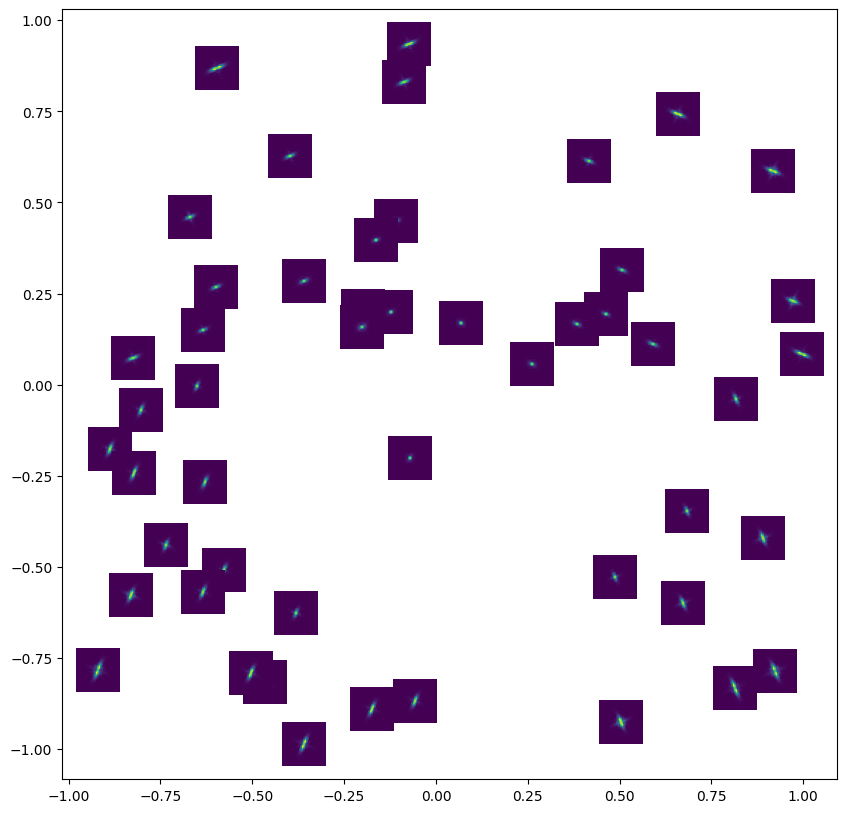

In [13]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def get_image(psf, zoom=1):
    return OffsetImage(psf, zoom=zoom)
plt.rcParams['figure.figsize'] = [10, 10]
mid_idx = psfs.shape[1]//2
mid_psfs = psfs[:, mid_idx, :, :]
fig, ax = plt.subplots()
ax.scatter(xy[:, 0], xy[:, 1]) 

for x0, y0, psf in zip(xy[:, 0], xy[:, 1], mid_psfs):
    ab = AnnotationBbox(get_image(psf), (x0, y0), frameon=False)
    ax.add_artist(ab)

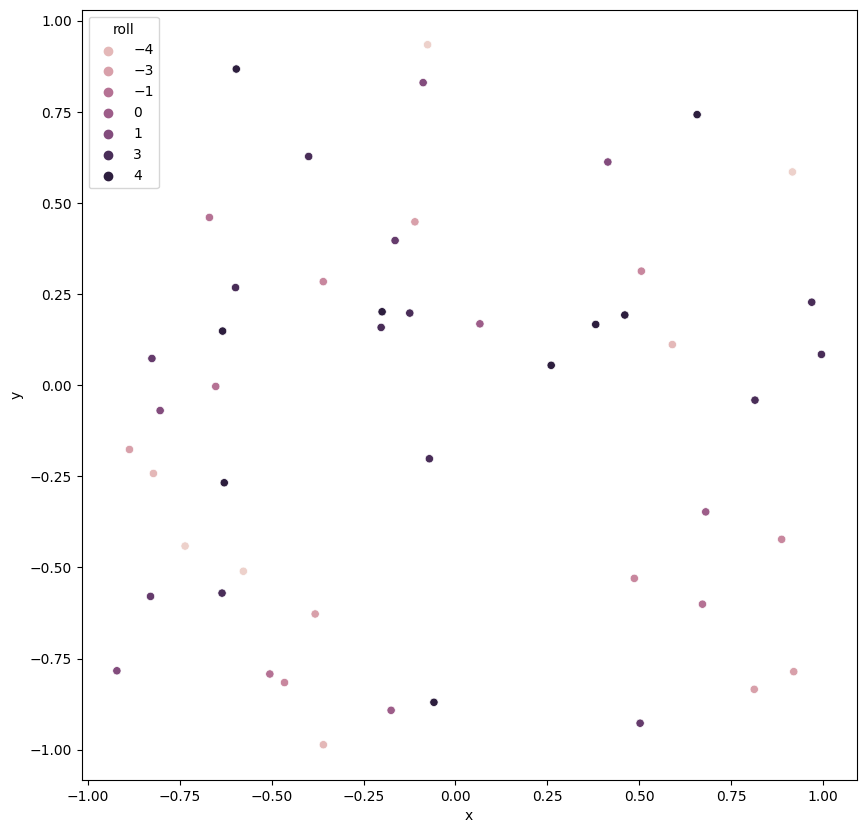

In [14]:
def roll_psf(psf, roll):
    rolled_psf = np.roll(psfs[i], shift=roll, axis=0)
    return rolled_psf

rolls = []
for i in range(psfs.shape[0]):
    roll = np.random.randint(-5, 5)
    psfs[i] = roll_psf(psfs[i], roll)
    rolls.append(roll)
df['roll'] = np.array(rolls)

sns.scatterplot(data=df, x='x', y='y', hue='roll')
plt.show()

In [15]:
BASELINE = 5
QUANTUM_EFFICIENCY = 0.69
DARK_NOISE = 10

def noise_psf(psf, baseline=BASELINE, qe=QUANTUM_EFFICIENCY, dn=DARK_NOISE, bitdepth=8, plot=False):
    psf = norm_zero_one(psf)
    psf = (psf * (2**bitdepth)).astype(int)
    photons = np.random.poisson(psf)
    electrons = jnp.round(photons * qe)
    electrons_out = electrons + np.random.normal(scale=dn, size=psf.shape)
    electrons_out += baseline

    noisy_psf = norm_zero_one(electrons_out)
    
    if plot:
        show_psf_axial(photons, 'photons')
        show_psf_axial(electrons, 'electons')
        show_psf_axial(electrons_out, 'electons out')
        show_psf_axial(noisy_psf, 'noisy')
    return noisy_psf

plt.rcParams['figure.figsize'] = [10, 10]
noisy_psfs = np.stack([noise_psf(psf, plot=False) for psf in psfs])
# noisy_psfs = psfs

In [16]:
import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.01'

import jax.numpy as jnp
import jax
import numpy as np

def rms2(ab, pupil):
    return np.sqrt(np.sum(ab**2) / np.sum(pupil <= 1))


def rms(pupil):
    return jnp.sqrt(jnp.mean(jnp.abs(pupil)**2))
          
def norm_zero_one(psf):
    return (psf - psf.min()) / (psf.max() - psf.min())


from jax.numpy.fft import fftn, fftshift, ifftn, ifftshift
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/miguel/Projects/uni/phd/smlm_z')
from data.visualise import show_psf_axial

def mask_psf(img, otf_mask=s.kr<=2, alpha=0.2, beta=1, plot=False):
    
    fft = fftshift(fftn(img, axes=(1,2)), axes=(1,2))
    

    att_mask = (1 - beta * jnp.exp(-s.kr ** 2 / (2 * alpha ** 2)))

    
    plt.rcParams["figure.figsize"] = (10, 5)

    mask = att_mask * (otf_mask).astype(int)
    
    if plot:
        show_psf_axial(norm_zero_one(np.real(fft)), 'imag')
        show_psf_axial(norm_zero_one(np.imag(fft)), 'real')        
        plt.imshow(mask)
        plt.show()
        
    fft = fft.at[:].set(jnp.multiply(fft[:], mask))
    
    if plot:
        show_psf_axial(norm_zero_one(np.real(fft)), 'imag_masked')
        show_psf_axial(norm_zero_one(np.imag(fft)), 'real_masked')
        plt.imshow(att_mask)
        plt.colorbar()
        plt.show()
        plt.imshow(np.imag(fft[50]))
        plt.show()
        show_psf_axial(np.imag(fft), 'Masked FFT')
    
    img2 = np.abs(ifftn(ifftshift(fft, axes=(1,2)), axes=(1,2)))
    
    if plot:
        show_psf_axial(img, 'Original')
        show_psf_axial(img2, 'Denoised')
        
    img2[img2<0] = 0
    return img2

denoised_psfs =  np.stack([mask_psf(psf, plot=False, alpha=0.1) for psf in noisy_psfs])

In [17]:
import scipy.optimize as opt

def bestfit_error(z_true, z_pred):

    def linfit(x, c):
        return x + c

    x = z_true
    y = z_pred
    popt, _ = opt.curve_fit(linfit, x, y, p0=[0])

    plt.scatter(x, y, label='pred')
    
    x = np.linspace(z_true.min(), z_true.max(), len(y))
    y_fit = linfit(x, popt[0])

    plt.plot(x, y_fit, label='fit', c='orange')
    plt.legend()
    plt.show()
    error = sum(abs(y_fit-y)) / len(y)
    return error



In [18]:
import networkx as nx
from scipy.spatial import Delaunay
from functools import lru_cache

import itertools

class GraphPSFAligner:
    def __init__(self, df, psfs, n_paths=5):
        self.df = df
        self.coords = df[['x', 'y']].to_numpy()
        self.seed_idx = self.find_seed_psf(self.coords)
        print(f'Seed PSF: {self.seed_idx}')
        self.psfs = psfs.copy()
        
        self.dists = euclidean_distances(self.coords)
        self.n_paths = n_paths
        
        self.G = self.delaunay(self.coords)

    def delaunay(self, coords):
        dt = Delaunay(points=coords)
        G = nx.Graph()
        for path in dt.simplices:
            nx.add_path(G, path)

        for src, target in G.edges:
            G[src][target]['weight'] = self.dists[src][target]
        pos = nx.circular_layout(G)
        n_points = self.coords.shape[0]
        for i in range(n_points):
            pos[i] = coords[i]
#         nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightgreen')
        return G

    def find_seed_psf(self, coords):
        # Seed PSF - most centered PSF in FOV
        center = coords.mean(axis=0)
        dists = euclidean_distances([center], coords).squeeze()
        first_point = np.argmin(dists)
        return first_point

    def find_offset(self, target_idx, debug=False):
        paths = list(itertools.islice(nx.shortest_simple_paths(self.G, target_idx, self.seed_idx, weight='weight'), self.n_paths))
        offsets = []
        for path in paths:
            path_dist = []
            for i in range(len(path)-1):
                path_dist.append(self.pairwise_offset(path[i], path[i+1]))
            offsets.append(sum(path_dist))
        
        med, var = np.median(offsets), np.var(offsets)
        if debug:
            true_val = self.df['roll'][target_idx] - self.df['roll'][self.seed_idx]
            print('Pred: ', offsets)
            print('Median, var: ', med, var)
            print('Mean, var: ', np.mean(offsets))
            print('True: ', true_val)
        
        return med, var
    
    def pairwise_offset(self, i, i2):
        raise NotImplementedError

    def align_all(self):
        res = []
        for i in trange(self.df.shape[0]):
            res.append(self.find_offset(i)[0])
        return np.array(res)

class PerfectAligner(GraphPSFAligner):
    def pairwise_offset(self, i, i2):
        return df['roll'][i] - df['roll'][i2]

i = 10
aligner = PerfectAligner(df, psfs, n_paths=10)
median, var = aligner.find_offset(i)


Seed PSF: 12


In [22]:
from keras.losses import MeanSquaredError
import numpy as np
from skimage.exposure import match_histograms
from sklearn.metrics.pairwise import euclidean_distances
from itertools import product
from functools import partial
import numpy as np
from scipy.interpolate import UnivariateSpline
from tqdm import trange
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/miguel/Projects/uni/phd/smlm_z')
from data.estimate_offset import get_peak_sharpness
from data.visualise import grid_psfs, show_psf_axial
from skimage.filters import gaussian

import numpy as np

import itertools

mse = MeanSquaredError()

DEBUG = False
UPSCALE_RATIO = 10


def norm_zero_one(s):
    max_s = s.max()
    min_s = s.min()
    return (s - min_s) / (max_s - min_s)

def pad_and_fit_spline(coords, psf, z, z_ups):
    x, y = coords
    zs = psf[:, x, y]
    cs = UnivariateSpline(z, zs, k=3, s=1e-1)
    # if max(cs(z_ups)) > 2:
    #     plt.plot(z, zs, label='raw')
    #     plt.plot(z_ups, cs(z_ups), '.', label='smooth')
    #     plt.legend()
    #     plt.show()
    return x, y, cs(z_ups)
    
def upsample_psf(psf, ratio=UPSCALE_RATIO):
    pad_width = 10
    z = np.arange(-pad_width, psf.shape[0] + pad_width)
    z_ups = np.arange(0, psf.shape[0], 1/ratio)
    upsampled_psf = np.zeros((z_ups.shape[0], *psf.shape[1:]))
    
    psf = np.pad(psf, ((pad_width, pad_width), (0, 0), (0, 0)), mode='edge')
    xys = list(product(np.arange(psf.shape[1]), np.arange(psf.shape[2])))
    func = partial(pad_and_fit_spline, psf=psf, z=z, z_ups=z_ups)
    res = list(map(func, xys))
    # with Pool(8) as p:
    #     res = list(p.imap(func, xys))
    for x, y, z_col in res:
        upsampled_psf[:, x, y] = z_col

    return upsampled_psf

def pad_psf(psf):
    return np.pad(psf, ((20, 20), (0, 0), (0, 0)), mode='edge')

def plot_correction(target, img, best_i, errors):

    psf_corrected = np.roll(img, int(best_i), axis=0)
    plt.plot(target.max(axis=(1,2)), label='target')
    plt.plot(img.max(axis=(1,2)),  label='original')
    plt.plot(psf_corrected.max(axis=(1,2)), label='corrected', )

    plt.legend()
    plt.show()

def tf_find_optimal_roll(target, img, upscale_ratio=UPSCALE_RATIO):
    ref_tf = tf.convert_to_tensor(target)
    img_tf = tf.convert_to_tensor(img)
    errors = []

    for i in range(img.shape[0]):
        error = tf.reduce_mean(mse(ref_tf, img_tf))
        errors.append(error)
        img_tf = tf.roll(img_tf, 1, axis=0)

    best_i = tf.argmin(errors).numpy()
    # Prefer small backwards roll to large forwards roll
    if abs(best_i - img.shape[0]) < best_i:
        best_i = best_i - img.shape[0]

    if DEBUG:
        plot_correction(target, img, best_i, errors)

    return best_i/upscale_ratio


def find_seed_psf(df):
    # Seed PSF - most centered PSF in FOV
    center = df[['x', 'y']].mean(axis=0).to_numpy()
    coords = df[['x', 'y']].to_numpy()
    dists = euclidean_distances([center], coords).squeeze()
    first_point = np.argmin(dists)
    return first_point

import numpy as np
import scipy.optimize as opt
import skimage.filters as filters
from tqdm import trange


def measure_psf_fwhm(psf):
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(-(x - mean) ** 2 / (2 * stddev ** 2))
    # Normalize the PSF to range [0, 1]
    psf_norm = (psf - np.min(psf)) / (np.max(psf) - np.min(psf))
    
    # Find the center of the PSF using the maximum intensity
    center = np.unravel_index(np.argmax(psf_norm), psf_norm.shape)
    # Extract a 1D slice of the PSF along the z-axis passing through the center
    z_slice = psf_norm[:, center[0]]
    
    # Estimate the initial parameters of the Gaussian fit
    amplitude = np.max(z_slice) - np.min(z_slice)
    mean = center[0]
    stddev = 2
    
    # Fit the Gaussian to the 1D slice using least squares optimization
    popt, _ = opt.curve_fit(gaussian, np.arange(z_slice.size), z_slice, p0=[amplitude, mean, stddev])
    
    # Compute the FWHM of the Gaussian fit
    fwhm = 2 * np.sqrt(2 * np.log(2)) * popt[2]
    
    return fwhm

def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2).astype(int)

    mask = dist_from_center <= radius
    return mask

def mask_img_stack(stack, radius):
    mask = create_circular_mask(stack.shape[1], stack.shape[2], radius=radius)
    for i in range(stack.shape[0]):
        stack[i][~mask] = 0
    return stack

def prepare_psf(psf):
    psf = gaussian(psf, sigma=1)
    psf = norm_zero_one(psf.copy())
    psf = pad_psf(psf)
    psf = upsample_psf(psf)
    psf = mask_img_stack(psf, 12)
    return psf


from skimage.exposure import match_histograms


class ClassicAligner(GraphPSFAligner):
    
    @lru_cache(maxsize=None)
    def pairwise_offset(self, i, i2):
        psf1 = prepare_psf(self.psfs[i])
        psf2 = prepare_psf(self.psfs[i2])
        psf1 = match_histograms(psf1, psf2)
        return -tf_find_optimal_roll(psf2, psf1)
    
aligner = ClassicAligner(df, psfs, n_paths=10)
offsets = aligner.align_all()
bestfit_error(aligner, offsets)

  0%|                                                                                                                              | 0/50 [00:00<?, ?it/s]

Seed PSF: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [06:25<00:00,  7.71s/it]


TypeError: unsupported operand type(s) for +: 'ClassicAligner' and 'int'

In [11]:
# REAL DATA
import pandas as pd
from tifffile import imread
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data_dir = '/home/miguel/Projects/uni/data/smlm_3d/20230331_beads/combined/'
locs_path = data_dir + 'locs.hdf'
stacks_path = data_dir + 'stacks.ome.tif'

n_psfs = real_df.shape[0]+1
real_df = pd.read_hdf(locs_path, key='locs')
real_df = real_df.iloc[0:n_psfs]
real_stacks = imread(stacks_path)
real_stacks = real_stacks[:n_psfs]

print(real_df.shape)
print(real_stacks.shape)

# offsets = [0,2,3]
# for i, offset in enumerate(offsets):
#     real_stacks[i] = np.roll(real_stacks[0], shift=offset, axis=0)


(87, 13)
(87, 150, 31, 31)


In [25]:
from sklearn.model_selection import train_test_split
psfs = np.concatenate(real_stacks)
psfs = psfs.astype(float)
psfs = psfs[:, :, :, np.newaxis]
psfs = np.repeat(psfs, repeats=3, axis=-1)

bit_depth = 2**16
train_psfs, val_psfs = train_test_split(psfs, test_size=0.3)
print(train_psfs.shape, val_psfs.shape)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

datagen.fit(train_psfs)

train_psfs = datagen.standardize(train_psfs)
val_psfs = datagen.standardize(val_psfs)



(9135, 31, 31, 3) (3915, 31, 31, 3)


-3.1364408761579554 18.73587860935574
-2.9220724610561444 18.73587860935574


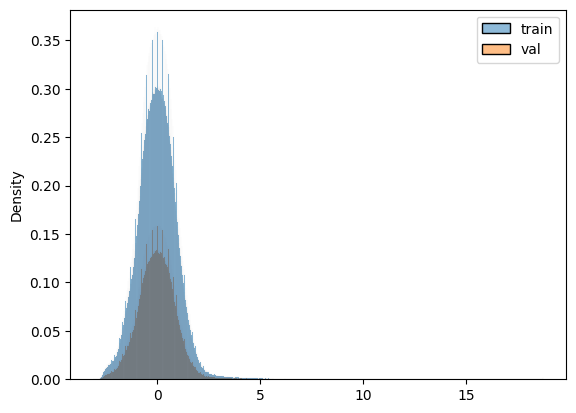

In [36]:
print(train_psfs.min(), train_psfs.max())
print(val_psfs.min(), val_psfs.max())

import seaborn as sns
data = {
    'train': train_psfs.flatten(),
    'val': val_psfs.flatten(),
}
sns.histplot(data, stat='density')
plt.show()


In [ ]:
def norm_psfs(psf):
    return np.stack([psf[i]/psf[i].sum() for i in range(psf.shape[0])])

real_stacks = np.stack([norm_psfs(psf) for psf in real_stacks])


In [ ]:
aligner = ClassicAligner(real_df, real_stacks, n_paths=10)
print(aligner.seed_idx)
plt.rcParams['figure.figsize'] = [3, 3]
plt.show()
real_df['offsets'] = aligner.align_all()
sns.scatterplot(data=real_df, x='x', y='y', hue='offsets')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

z_coords_base = np.arange(real_stacks.shape[1])
all_z_coords = []
plt.rcParams['figure.figsize'] = [5, 5]
for i, offsets in enumerate(list(real_df['offsets'])):
    z_coords = z_coords_base-offsets
    all_z_coords.append(z_coords)
    ys = real_stacks[i].max(axis=(1,2))
    ys = norm_zero_one(ys)
    plt.plot(z_coords, ys)
plt.show()
all_z_coords = np.array(all_z_coords).flatten()
all_psfs = real_stacks.reshape((-1, *real_stacks.shape[2:]))
print(all_z_coords.shape)
print(all_psfs.shape)

plt.rcParams['figure.figsize'] = [30, 30]

idx = np.argsort(all_z_coords)
plt.imshow(grid_psfs(all_psfs[idx]))
plt.show()